In [1]:
import sys

src_dir = '../src'

if src_dir not in sys.path:
    sys.path.append(src_dir)

## Dataloaders

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from classifier.dataloader.dataloader import create_dataloaders
from classifier.models.simple_net import NeuralNetwork

In [3]:
torch.manual_seed(0)

In [4]:
data_raw_path = '../data/data_raw.csv'
batch_size = 32
max_features = 1e4
train_ratio = .7
val_ratio = .15
shuffle = True

(

    train_loader, 
    val_loader, 
    test_loader

) = create_dataloaders(

    csv_path=data_raw_path,
    vectorization='tf-idf',
    batch_size=batch_size,
    max_features=int(max_features),
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    shuffle=shuffle

)

## Naive Bayes

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [6]:
data_path = '../data/data_raw.csv'  
df = pd.read_csv(data_path)

df['target'] = df['target'].replace({1: 1, 2: 1, 3: 2, 4: 3, 5: 3})

print("New label distribution:\n", df['target'].value_counts())

New label distribution:
 target
2    3465
1    3415
3    3120
Name: count, dtype: int64


In [7]:
X = df['features']
y = df['target']

vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(X).toarray()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
nb_classifier = MultinomialNB(alpha=1)
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

           1       0.61      0.56      0.58       683
           2       0.43      0.50      0.46       693
           3       0.52      0.46      0.48       624

    accuracy                           0.51      2000
   macro avg       0.52      0.51      0.51      2000
weighted avg       0.52      0.51      0.51      2000



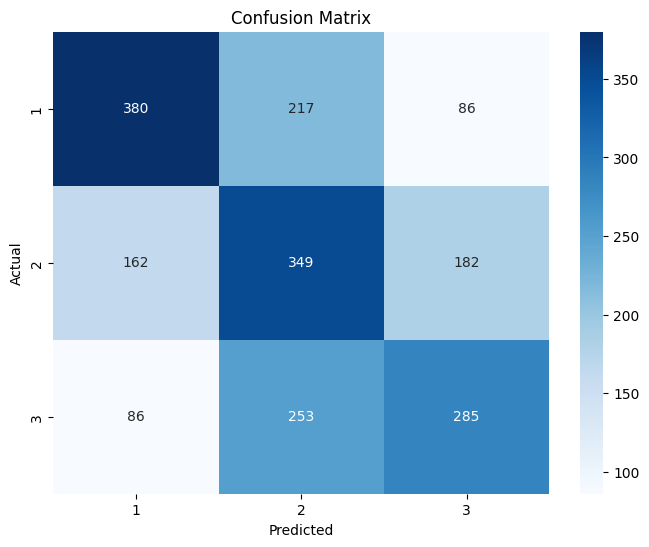

In [10]:
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Naive Bayes with penalty

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
cost_matrix = {
    (1, 2): 1,  # Easy -> Medium
    (1, 3): 3,  # Easy -> Hard
    (2, 1): 1,  # Medium -> Easy
    (2, 3): 1,  # Medium -> Hard
    (3, 1): 3,  # Hard -> Easy
    (3, 2): 1   # Hard -> Medium
}

In [13]:
data_path = '../data/data_raw.csv'
df = pd.read_csv(data_path)

df['target'] = df['target'].replace({1: 1, 2: 1, 3: 2, 4: 3, 5: 3})

X = df['features']
y = df['target']

In [14]:
vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 2))
X_vectorized = vectorizer.fit_transform(X)

In [15]:
sample_weights = np.ones(len(y)) 

for i in range(len(y)):
    actual_class = y.iloc[i]
    predicted_class = actual_class 
    if (actual_class, predicted_class) in cost_matrix:
        sample_weights[i] = cost_matrix[(actual_class, predicted_class)]

In [16]:
X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(
    X_vectorized, y, sample_weights, test_size=0.2, random_state=42)

In [17]:
model = MultinomialNB()
model.fit(X_train, y_train, sample_weight=sample_weights_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.513
              precision    recall  f1-score   support

           1       0.60      0.57      0.58       676
           2       0.42      0.49      0.46       691
           3       0.55      0.48      0.51       633

    accuracy                           0.51      2000
   macro avg       0.52      0.51      0.52      2000
weighted avg       0.52      0.51      0.52      2000



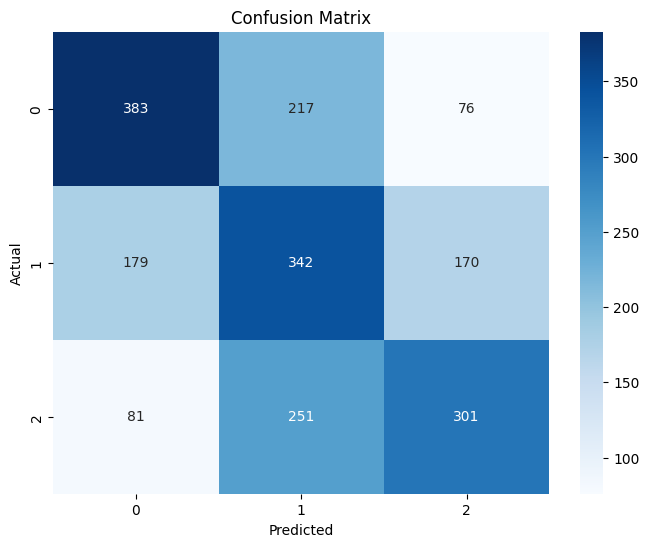

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Naive Bayes hierachical

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
data_path = '../data/data_raw.csv' 
df = pd.read_csv(data_path)

df['target'] = df['target'].replace({1: 1, 2: 1, 3: 2, 4: 3, 5: 3})

X = df['features']
y = df['target'].reset_index(drop=True)

In [21]:
stage1_labels = y.replace({1: 1, 2: 0, 3: 0})

from imblearn.over_sampling import RandomOverSampler

X_train_stage1, X_test_stage1, y_train_stage1, y_test_stage1 = train_test_split(
    X, stage1_labels, test_size=0.3, random_state=42, stratify=stage1_labels
)

X_train_stage1 = X_train_stage1.reset_index(drop=True)
y_train_stage1 = y_train_stage1.reset_index(drop=True)
X_test_stage1 = X_test_stage1.reset_index(drop=True)
y_test_stage1 = y_test_stage1.reset_index(drop=True)

ros = RandomOverSampler(random_state=42)
X_train_stage1_resampled, y_train_stage1_resampled = ros.fit_resample(
    pd.DataFrame(X_train_stage1), y_train_stage1
)

In [22]:
vectorizer_stage1 = TfidfVectorizer(max_features=10000)
X_train_vec_stage1 = vectorizer_stage1.fit_transform(X_train_stage1_resampled.squeeze())
X_test_vec_stage1 = vectorizer_stage1.transform(X_test_stage1)

In [23]:
nb_stage1 = MultinomialNB()
nb_stage1.fit(X_train_vec_stage1, y_train_stage1_resampled)

y_pred_stage1 = nb_stage1.predict(X_test_vec_stage1)

print("Stage 1 - Medium/Hard vs Easy Classification Report:\n")
print(
    classification_report(
        y_test_stage1, y_pred_stage1, target_names=['Medium/Hard', 'Easy']
    )
)

Stage 1 - Medium/Hard vs Easy Classification Report:

              precision    recall  f1-score   support

 Medium/Hard       0.77      0.77      0.77      1976
        Easy       0.56      0.55      0.55      1024

    accuracy                           0.70      3000
   macro avg       0.66      0.66      0.66      3000
weighted avg       0.70      0.70      0.70      3000



In [24]:
test_indices_stage2 = X_test_stage1.index[y_pred_stage1 == 0]
train_indices_stage2 = X_train_stage1_resampled.index[y_train_stage1_resampled == 0]

X_train_stage2 = X_train_stage1_resampled.loc[train_indices_stage2].reset_index(drop=True)
y_train_stage2 = y.loc[X_train_stage1_resampled.index[train_indices_stage2]].reset_index(drop=True)

X_test_stage2 = X_test_stage1.loc[test_indices_stage2].reset_index(drop=True)
y_test_stage2 = y.loc[X_test_stage1.index[test_indices_stage2]].reset_index(drop=True)

print("Stage 2 Training Class Distribution:")
print(y_train_stage2.value_counts())

ros_stage2 = RandomOverSampler(random_state=42)
X_train_stage2_resampled, y_train_stage2_resampled = ros_stage2.fit_resample(
    pd.DataFrame(X_train_stage2), y_train_stage2
)

Stage 2 Training Class Distribution:
target
2    1603
3    1577
1    1429
Name: count, dtype: int64


In [25]:
vectorizer_stage2 = TfidfVectorizer(max_features=10000)
X_train_vec_stage2 = vectorizer_stage2.fit_transform(X_train_stage2_resampled.squeeze())
X_test_vec_stage2 = vectorizer_stage2.transform(X_test_stage2)

In [26]:
nb_stage2 = MultinomialNB()
nb_stage2.fit(X_train_vec_stage2, y_train_stage2_resampled)

y_pred_stage2 = nb_stage2.predict(X_test_vec_stage2)

In [27]:
final_predictions = pd.Series(y_pred_stage1, index=X_test_stage1.index)

final_predictions.replace({1: 1}, inplace=True) 

final_predictions.loc[test_indices_stage2] = y_pred_stage2

final_predictions = final_predictions.astype(int)

y_test_full = y.loc[X_test_stage1.index].reset_index(drop=True)

target_names = ['Easy', 'Medium', 'Hard']

print("Final Hierarchical Classification Report:\n")
print(
    classification_report(
        y_test_full, final_predictions, target_names=target_names
    )
)

Final Hierarchical Classification Report:

              precision    recall  f1-score   support

        Easy       0.27      0.58      0.37       803
      Medium       0.36      0.22      0.28      1113
        Hard       0.36      0.19      0.25      1084

    accuracy                           0.31      3000
   macro avg       0.33      0.33      0.30      3000
weighted avg       0.34      0.31      0.29      3000



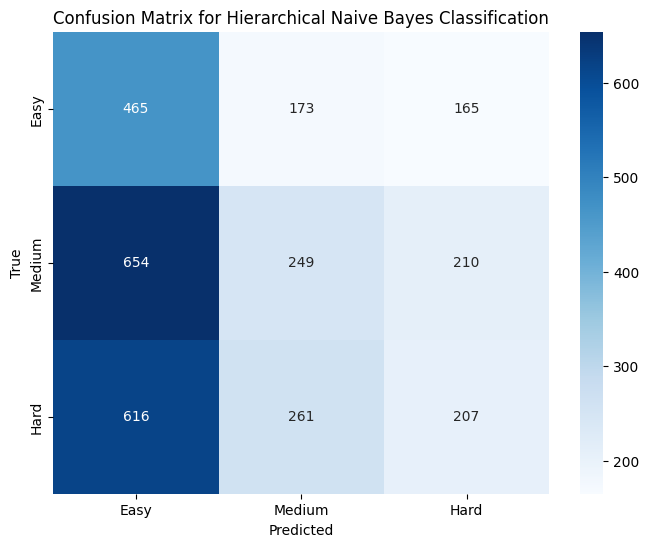

In [28]:
conf_mat = confusion_matrix(y_test_full, final_predictions, labels=[1, 2, 3])
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Hierarchical Naive Bayes Classification')
plt.show()

## Naive Bayes Ensemble

In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import VotingClassifier
from collections import Counter

df = pd.read_csv('../data/data_raw.csv')

df['target'] = df['target'].replace({1: 1, 2: 1, 3: 2, 4: 3, 5: 3})

X = df['features']
y = df['target']

In [30]:
vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = vectorizer.fit_transform(X).toarray()

print("TF-IDF feature matrix shape:", X_tfidf.shape)

TF-IDF feature matrix shape: (10000, 10000)


In [31]:
pca = PCA(n_components=1000, random_state=42)
X_pca = pca.fit_transform(X_tfidf)

print("PCA-reduced feature matrix shape:", X_pca.shape)

PCA-reduced feature matrix shape: (10000, 1000)


In [32]:
num_chunks = 5

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
chunk_size = len(X_train) // num_chunks

X_chunks, y_chunks = [], []

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size if i != num_chunks - 1 else len(X_train)
    
    X_chunk, y_chunk = X_train[start_idx:end_idx], y_train.iloc[start_idx:end_idx]
    
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_chunk, y_chunk)
    
    X_chunks.append(X_resampled)
    y_chunks.append(y_resampled)

for i, y_chunk in enumerate(y_chunks):
    print(f"Class distribution in chunk {i + 1}:", Counter(y_chunk))

Class distribution in chunk 1: Counter({2: 603, 1: 603, 3: 603})
Class distribution in chunk 2: Counter({3: 536, 2: 536, 1: 536})
Class distribution in chunk 3: Counter({3: 573, 1: 573, 2: 573})
Class distribution in chunk 4: Counter({1: 549, 3: 549, 2: 549})
Class distribution in chunk 5: Counter({1: 564, 2: 564, 3: 564})


In [33]:
naive_bayes_models = []

for i, (X_chunk, y_chunk) in enumerate(zip(X_chunks, y_chunks)):
    model = GaussianNB()
    
    model.fit(X_chunk, y_chunk)
    
    naive_bayes_models.append(model)
    print(f"Naive Bayes model {i + 1} trained on chunk {i + 1}.")

Naive Bayes model 1 trained on chunk 1.
Naive Bayes model 2 trained on chunk 2.
Naive Bayes model 3 trained on chunk 3.
Naive Bayes model 4 trained on chunk 4.
Naive Bayes model 5 trained on chunk 5.


In [34]:
ensemble_model = VotingClassifier(
    estimators=[(f'nb_{i + 1}', model) for i, model in enumerate(naive_bayes_models)],
    voting='hard'
)

ensemble_model.fit(X_train, y_train)
print("Ensemble Naive Bayes model trained.")

Ensemble Naive Bayes model trained.


In [35]:
y_pred = ensemble_model.predict(X_test)

print("Classification Report for Ensemble Naive Bayes Model:\n")
print(classification_report(y_test, y_pred, target_names=['Easy', 'Medium', 'Hard']))

conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for Ensemble Naive Bayes Model:\n", conf_mat)

Classification Report for Ensemble Naive Bayes Model:

              precision    recall  f1-score   support

        Easy       0.42      0.56      0.48       676
      Medium       0.41      0.16      0.23       691
        Hard       0.35      0.46      0.40       633

    accuracy                           0.39      2000
   macro avg       0.39      0.39      0.37      2000
weighted avg       0.39      0.39      0.37      2000

Confusion Matrix for Ensemble Naive Bayes Model:
 [[381  62 233]
 [277 109 305]
 [247  96 290]]


## Oridinal Logistic Regression

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

import mord

In [37]:
df = pd.read_csv('../data/data_raw.csv')

df['target'] = df['target'].replace({1: 1, 2: 1, 3: 2, 4: 3, 5: 3})

X = df['features']
y = df['target']

In [38]:
vectorizer = TfidfVectorizer(max_features=10000)
X_vectorized = vectorizer.fit_transform(X)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.3, random_state=42)

In [40]:
import numpy as np

class_weights = {1: 2.0, 2: 1.0, 3: 2.0}  # Higher weights for 'Easy' and 'Hard'
sample_weights = np.array([class_weights[label] for label in y_train])

model = mord.LogisticAT()
model.fit(X_train, y_train, sample_weight=sample_weights)

LogisticAT()

In [41]:
y_pred = model.predict(X_test)

print("Classification Report for Ordinal Logistic Regression:\n")
print(classification_report(y_test, y_pred, target_names=['Easy', 'Medium', 'Hard']))

conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mat)

Classification Report for Ordinal Logistic Regression:

              precision    recall  f1-score   support

        Easy       0.57      0.55      0.56      1016
      Medium       0.40      0.41      0.41      1059
        Hard       0.53      0.53      0.53       925

    accuracy                           0.50      3000
   macro avg       0.50      0.50      0.50      3000
weighted avg       0.50      0.50      0.50      3000

Confusion Matrix:
 [[563 334 119]
 [311 438 310]
 [111 327 487]]


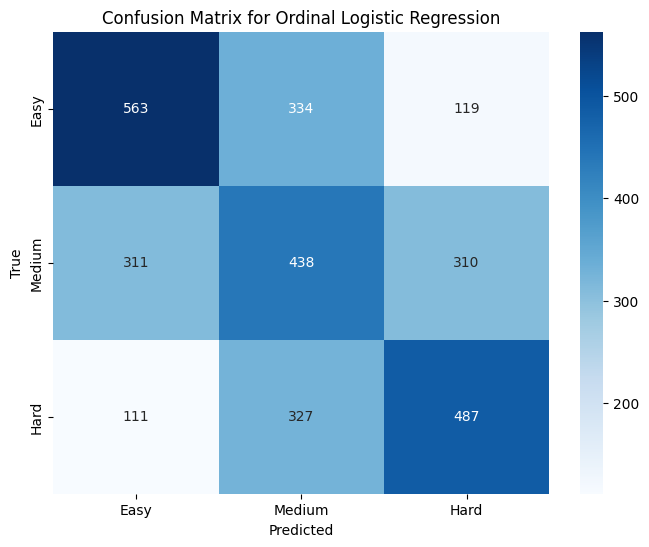

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Easy', 'Medium', 'Hard'], yticklabels=['Easy', 'Medium', 'Hard'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Ordinal Logistic Regression')
plt.show()

## Random Forest

In [43]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
data = pd.read_csv('../data/data_raw.csv')

data['target'] = data['target'].replace({1: 1, 2: 1, 3: 2, 4: 3, 5: 3})

features = data['features']
target = data['target']

In [45]:
vectorizer = TfidfVectorizer(max_features=10000)
features_tfidf = vectorizer.fit_transform(features).toarray()

X_train, X_test, y_train, y_test = train_test_split(features_tfidf, target, test_size=0.3, random_state=42, stratify=target)

In [46]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

           1       0.58      0.53      0.55      1025
           2       0.41      0.49      0.45      1039
           3       0.53      0.49      0.51       936

    accuracy                           0.50      3000
   macro avg       0.51      0.50      0.50      3000
weighted avg       0.51      0.50      0.50      3000

Accuracy Score: 0.5


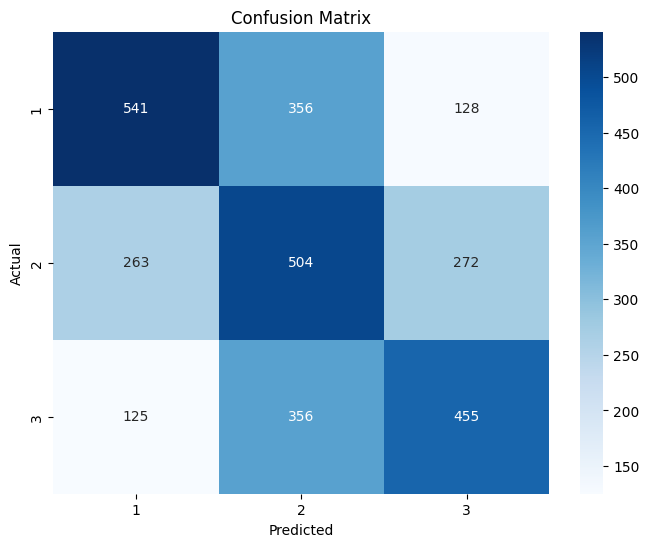

In [47]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Random Forest with penalty

In [48]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [49]:
data_path = '../data/data_raw.csv'

df = pd.read_csv(data_path)

df['target'] = df['target'].replace({1: 1, 2: 1, 3: 2, 4: 3, 5: 3})

X = df['features']
y = df['target']

In [50]:
vectorizer = TfidfVectorizer(max_features=10000)
X_vectorized = vectorizer.fit_transform(X)

class_weights = {
    1: 1.5,  # Give more importance to 'Easy' class 
    2: 1.0,  # Neutral importance for 'Medium' class
    3: 1.5   # Give more importance to 'Hard' class
}

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [51]:
rf_model = RandomForestClassifier(class_weight=class_weights, random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5025
              precision    recall  f1-score   support

           1       0.55      0.59      0.57       676
           2       0.42      0.37      0.39       691
           3       0.52      0.56      0.54       633

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



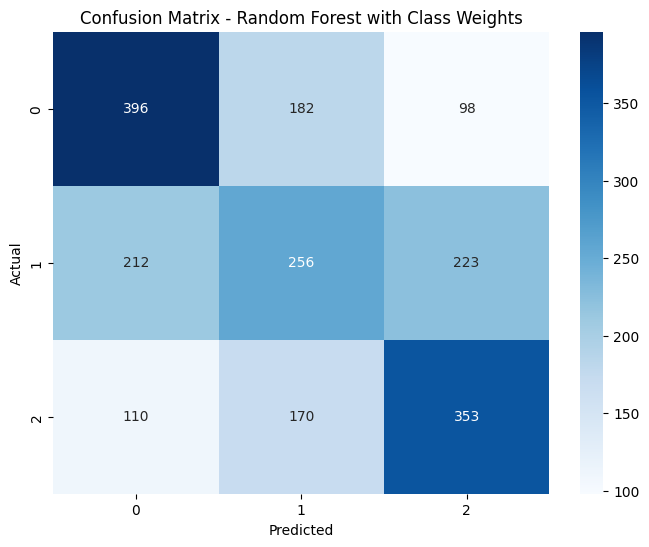

In [52]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix - Random Forest with Class Weights')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Training of simple dense net

In [53]:
learning_rate = 0.001
epochs = 5

input_size = int(max_features)
hidden_sizes = [128, 64]

model = NeuralNetwork(
    input_size=input_size,
    hidden_sizes=hidden_sizes
)

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
from classifier.training_loop import train, evaluate

In [56]:
train(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    data_loader=train_loader, 
    epochs=epochs
)

Epoch 1/5:   0%|          | 0/219 [00:00<?, ?batch/s]

Epoch 2/5:   0%|          | 0/219 [00:00<?, ?batch/s]

Epoch 3/5:   0%|          | 0/219 [00:00<?, ?batch/s]

Epoch 4/5:   0%|          | 0/219 [00:00<?, ?batch/s]

Epoch 5/5:   0%|          | 0/219 [00:00<?, ?batch/s]

In [57]:
average_loss, accuracy = evaluate(
    model=model,
    criterion=criterion,
    data_loader=test_loader
)

Average Loss: 1.5281, Accuracy: 46.47%


## Convolutional network

In [58]:
from classifier.models.conv_net import ConvolutionalNetwork

In [59]:
learning_rate = 0.001
epochs = 5

input_size = int(max_features)

model = ConvolutionalNetwork(
    input_features=input_size,
)

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [61]:
train(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    data_loader=train_loader, 
    epochs=epochs
)

Epoch 1/5:   0%|          | 0/219 [00:00<?, ?batch/s]

Epoch 2/5:   0%|          | 0/219 [00:00<?, ?batch/s]

Epoch 3/5:   0%|          | 0/219 [00:00<?, ?batch/s]

Epoch 4/5:   0%|          | 0/219 [00:00<?, ?batch/s]

Epoch 5/5:   0%|          | 0/219 [00:00<?, ?batch/s]

In [62]:
average_loss, accuracy = evaluate(
    model=model,
    criterion=criterion,
    data_loader=test_loader
)

Average Loss: 1.6121, Accuracy: 46.47%


## Embedding network

In [63]:
from classifier.models.embedded_net import EmbeddingConvolutionalNetwork

In [64]:
data_raw_path = '../data/data_raw.csv'
batch_size = 32
max_features = 1e4
train_ratio = .7
val_ratio = .15
shuffle = True

(

    train_loader, 
    val_loader, 
    test_loader

) = create_dataloaders(

    csv_path=data_raw_path,
    vectorization='count',
    batch_size=batch_size,
    max_features=int(max_features),
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    shuffle=shuffle

)

/home/lewelotki/.cache/pypoetry/virtualenvs/sudoku-classifier-ImMA5acm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [65]:
learning_rate = 0.001
epochs = 5

vocab_size = 10000  
embedding_dim = 100 
sequence_length = 100

model = EmbeddingConvolutionalNetwork(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    sequence_length=sequence_length
)

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [67]:
train(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    data_loader=train_loader, 
    epochs=epochs
)

Epoch 1/5:   0%|          | 0/219 [00:00<?, ?batch/s]

Epoch 2/5:   0%|          | 0/219 [00:00<?, ?batch/s]

Epoch 3/5:   0%|          | 0/219 [00:00<?, ?batch/s]

Epoch 4/5:   0%|          | 0/219 [00:00<?, ?batch/s]

Epoch 5/5:   0%|          | 0/219 [00:00<?, ?batch/s]

In [68]:
average_loss, accuracy = evaluate(
    model=model,
    criterion=criterion,
    data_loader=test_loader
)

Average Loss: 1.1149, Accuracy: 36.00%


## Oridinal Neural Network

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
data_raw_path = '../data/data_raw.csv'
batch_size = 32
max_features = 1e4
train_ratio = .7
val_ratio = .15
shuffle = True

(

    train_loader, 
    val_loader, 
    test_loader

) = create_dataloaders(

    csv_path=data_raw_path,
    vectorization='tf-idf',
    batch_size=batch_size,
    max_features=int(max_features),
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    shuffle=shuffle

)

In [71]:
class OrdinalNet(nn.Module):
    def __init__(self, input_size, num_classes=3):
        super(OrdinalNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

In [72]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        if labels.dim() > 1:
            labels = torch.argmax(labels, dim=1)
        optimizer.zero_grad()
        logits = model(inputs)
        labels = labels.long()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [73]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            
            inputs, labels = inputs.to(device), labels.to(device)         
            if labels.dim() > 1:
                labels = torch.argmax(labels, dim=1)
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(logits, dim=1).cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    return y_true, y_pred, avg_loss

Epoch 1/10
Training Loss: 1.0233
Test Loss: 0.9672
Classification Report:
               precision    recall  f1-score   support

        Easy       0.54      0.62      0.58       474
      Medium       0.40      0.29      0.33       547
        Hard       0.51      0.60      0.55       479

    accuracy                           0.49      1500
   macro avg       0.48      0.50      0.49      1500
weighted avg       0.48      0.49      0.48      1500



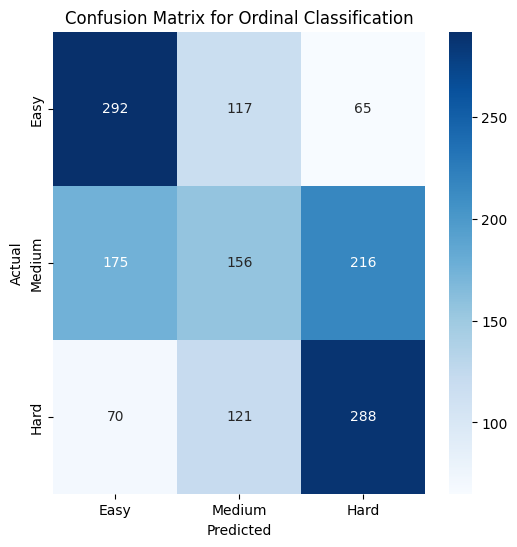

Epoch 2/10
Training Loss: 0.8503
Test Loss: 0.9826
Classification Report:
               precision    recall  f1-score   support

        Easy       0.59      0.47      0.52       474
      Medium       0.42      0.48      0.45       547
        Hard       0.53      0.56      0.54       479

    accuracy                           0.50      1500
   macro avg       0.51      0.50      0.50      1500
weighted avg       0.51      0.50      0.50      1500



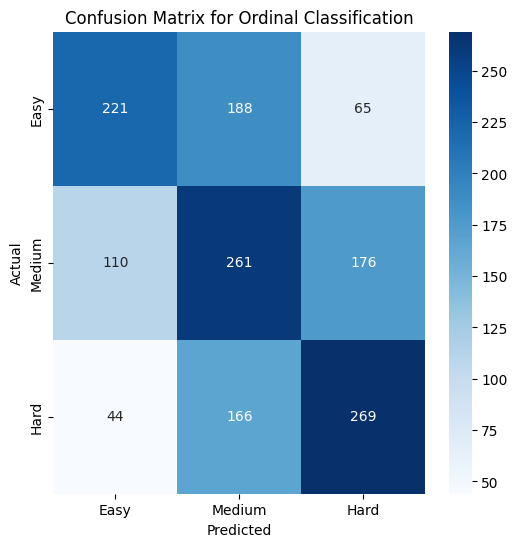

Epoch 3/10
Training Loss: 0.6750
Test Loss: 1.0702
Classification Report:
               precision    recall  f1-score   support

        Easy       0.56      0.50      0.53       474
      Medium       0.43      0.46      0.44       547
        Hard       0.51      0.53      0.52       479

    accuracy                           0.49      1500
   macro avg       0.50      0.49      0.50      1500
weighted avg       0.50      0.49      0.49      1500



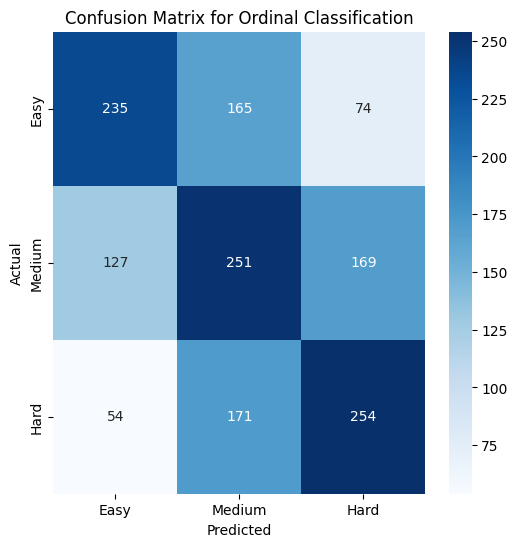

Epoch 4/10
Training Loss: 0.5188
Test Loss: 1.2414
Classification Report:
               precision    recall  f1-score   support

        Easy       0.55      0.51      0.53       474
      Medium       0.44      0.32      0.37       547
        Hard       0.47      0.65      0.55       479

    accuracy                           0.49      1500
   macro avg       0.49      0.50      0.48      1500
weighted avg       0.49      0.49      0.48      1500



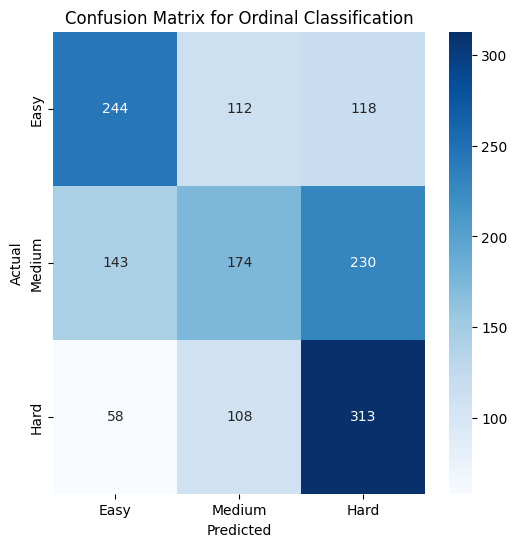

Epoch 5/10
Training Loss: 0.4042
Test Loss: 1.4174
Classification Report:
               precision    recall  f1-score   support

        Easy       0.52      0.54      0.53       474
      Medium       0.44      0.41      0.43       547
        Hard       0.49      0.51      0.50       479

    accuracy                           0.48      1500
   macro avg       0.48      0.49      0.49      1500
weighted avg       0.48      0.48      0.48      1500



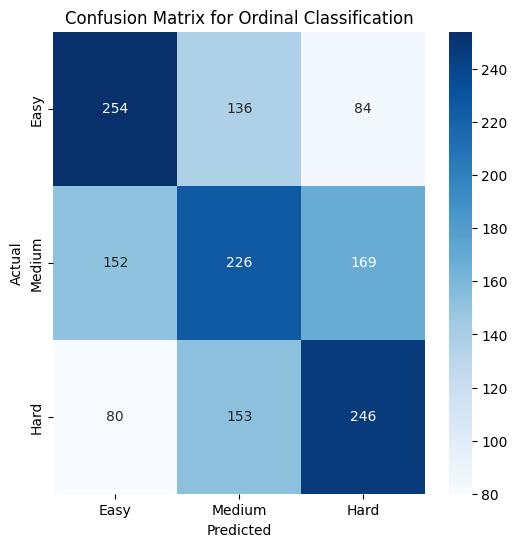

Epoch 6/10
Training Loss: 0.3125
Test Loss: 1.5765
Classification Report:
               precision    recall  f1-score   support

        Easy       0.50      0.56      0.53       474
      Medium       0.43      0.40      0.42       547
        Hard       0.51      0.48      0.50       479

    accuracy                           0.48      1500
   macro avg       0.48      0.48      0.48      1500
weighted avg       0.48      0.48      0.48      1500



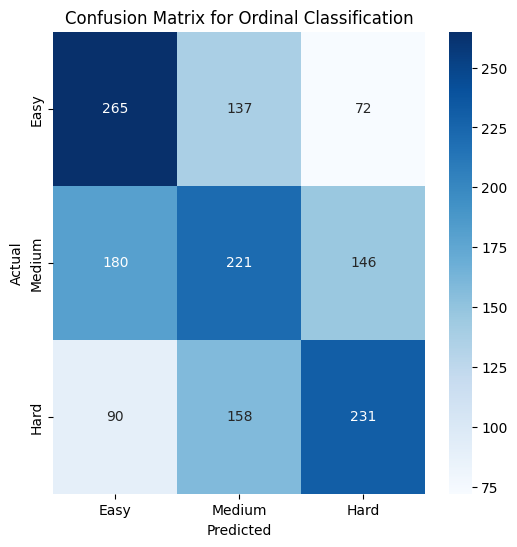

Epoch 7/10
Training Loss: 0.2476
Test Loss: 1.7718
Classification Report:
               precision    recall  f1-score   support

        Easy       0.49      0.52      0.51       474
      Medium       0.43      0.44      0.43       547
        Hard       0.52      0.49      0.50       479

    accuracy                           0.48      1500
   macro avg       0.48      0.48      0.48      1500
weighted avg       0.48      0.48      0.48      1500



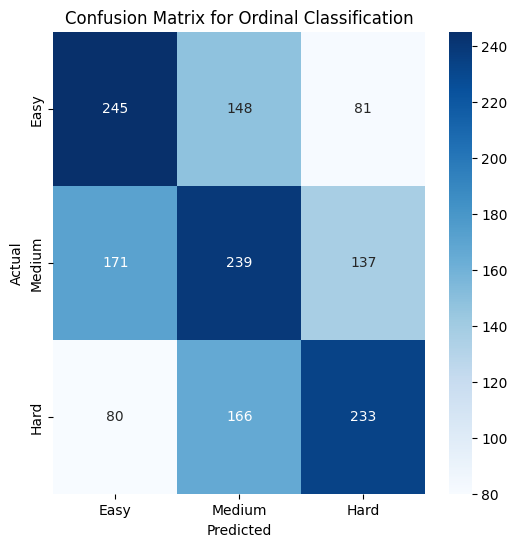

Epoch 8/10
Training Loss: 0.2073
Test Loss: 1.9528
Classification Report:
               precision    recall  f1-score   support

        Easy       0.51      0.50      0.50       474
      Medium       0.44      0.39      0.41       547
        Hard       0.49      0.55      0.52       479

    accuracy                           0.48      1500
   macro avg       0.48      0.48      0.48      1500
weighted avg       0.47      0.48      0.47      1500



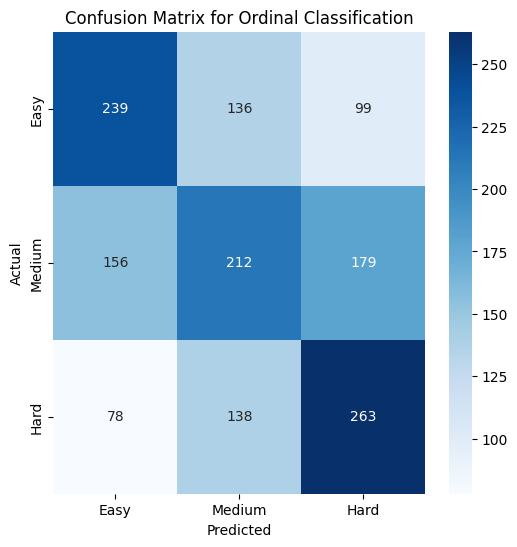

Epoch 9/10
Training Loss: 0.1744
Test Loss: 2.1107
Classification Report:
               precision    recall  f1-score   support

        Easy       0.50      0.53      0.51       474
      Medium       0.43      0.40      0.41       547
        Hard       0.50      0.50      0.50       479

    accuracy                           0.47      1500
   macro avg       0.48      0.48      0.48      1500
weighted avg       0.47      0.47      0.47      1500



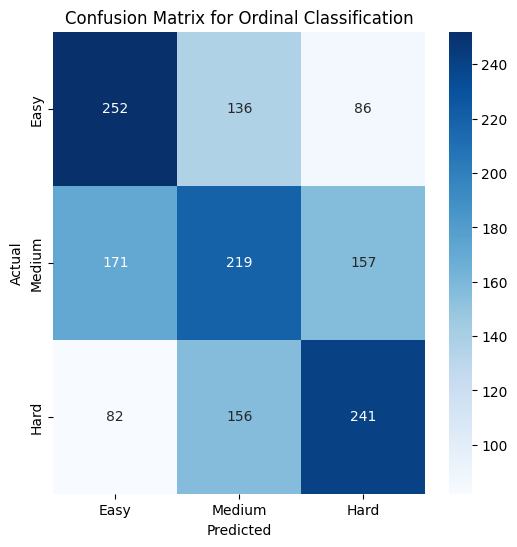

Epoch 10/10
Training Loss: 0.1546
Test Loss: 2.2444
Classification Report:
               precision    recall  f1-score   support

        Easy       0.50      0.52      0.51       474
      Medium       0.43      0.43      0.43       547
        Hard       0.50      0.48      0.49       479

    accuracy                           0.48      1500
   macro avg       0.48      0.48      0.48      1500
weighted avg       0.48      0.48      0.48      1500



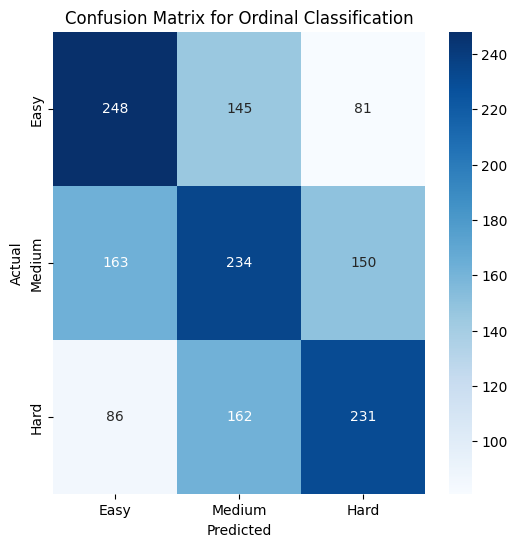

In [74]:
def training_loop():
    input_size = train_loader.dataset[0][0].shape[0]
    num_classes = 3
    learning_rate = 0.001
    num_epochs = 10

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = OrdinalNet(input_size=input_size, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        train_loss = train(model, train_loader, criterion, optimizer, device)
        print(f"Training Loss: {train_loss:.4f}")

        y_true, y_pred, test_loss = evaluate(model, test_loader, criterion, device)
        print(f"Test Loss: {test_loss:.4f}")
        
        print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Easy', 'Medium', 'Hard']))
        
        conf_mat = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Easy', 'Medium', 'Hard'], yticklabels=['Easy', 'Medium', 'Hard'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix for Ordinal Classification')
        plt.show()

training_loop()